--- 0.7196464538574219 seconds ---


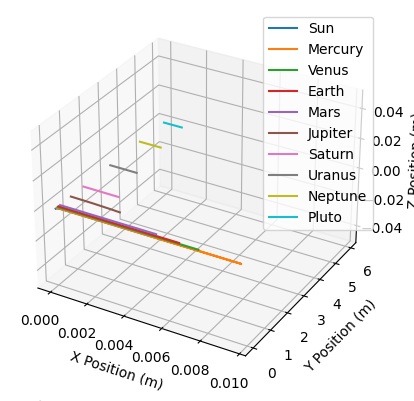

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from numba import jit

class body:
    def __init__(self, location, mass, velocity, name=""):
        self.location = np.array(location, dtype=np.float64) 
        self.mass = mass
        self.velocity = np.array(velocity, dtype=np.float64)
        self.name = name

@jit(nopython=True)
def n_body_equations(t, y, masses):
    n = len(masses)
    positions = y[:3*n].reshape((n, 3))
    velocities = y[3*n:].reshape((n, 3))
    accelerations = np.zeros((n, 3))

    for i in range(n):
        for j in range(i+1, n):  # Calculate each interaction only once
            r_vector = positions[j] - positions[i]
            r = np.sqrt(np.sum(r_vector**2))  # Manually compute the Euclidean norm
            force = G_const * masses[i] * masses[j] / r**3

            # Update the acceleration of both bodies
            accelerations[i] += force * r_vector
            accelerations[j] -= force * r_vector

    return np.concatenate((velocities.ravel(), accelerations.ravel()))


# Constants
G_const = 6.67430e-11  # m^3 kg^-1 s^-2

# Planet data (location (m), mass (kg), velocity (m/s))
planets = {
    "Sun": body((0, 0, 0), 2e30, (0, 0, 0), "Sun"),
    "Mercury": body((0, 5.79e10, 0), 3.285e23, (47000, 0, 0), "Mercury"),
    "Venus": body((0, 1.082e11, 0), 4.8e24, (35000, 0, 0), "Venus"),
    "Earth": body((0, 1.496e11, 0), 5.972e24, (30000, 0, 0), "Earth"),
    "Mars": body((0, 2.28e11, 0), 2.4e24, (24000, 0, 0), "Mars"),
    "Jupiter": body((0, 7.785e11, 0), 1e28, (13000, 0, 0), "Jupiter"),
    "Saturn": body((0, 1.432e12, 0), 5.7e26, (9000, 0, 0), "Saturn"),
    "Uranus": body((0, 2.867e12, 0), 8.7e25, (6835, 0, 0), "Uranus"),
    "Neptune": body((0, 4.515e12, 0), 1e26, (5477, 0, 0), "Neptune"),
    "Pluto": body((0, 5.9064e12, 0), 1.3e22, (4748, 0, 0), "Pluto")
}

bodies = [planets[name] for name in planets]

# Prepare initial conditions and masses
initial_positions = np.array([b.location for b in bodies])
initial_velocities = np.array([b.velocity for b in bodies])
initial_conditions = np.concatenate([initial_positions.ravel(), initial_velocities.ravel()])
masses = np.array([b.mass for b in bodies])

# Time span for the simulation
time_span = [0, 1000 * 365 * 24 * 3600]  # One year in seconds

# Solve the ODE
import time
start_time = time.time()
# Using 'LSODA' as the solver method and adjusting tolerances
solver_method = 'RK45'
atol = 1e-9  # Absolute tolerance
rtol = 1e-6  # Relative tolerance

try:
    solution = solve_ivp(n_body_equations, time_span, initial_conditions, args=(masses,),
                         method=solver_method, atol=atol, rtol=rtol)
    status_message = (solution.status, solution.message)
    final_time = solution.t[-1]
except Exception as e:
    error_message = str(e)
    status_message = None
    final_time = None

status_message, final_time
print("--- %s seconds ---" % (time.time() - start_time))
# Post-process the solution for plotting
n = len(bodies)
times = solution.t

positions = solution.y[:3*n].reshape(n, 3, -1)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
for i, body in enumerate(bodies):
    ax.plot(positions[i, 0], positions[i, 1], positions[i, 2], label=body.name)

ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
ax.legend()
plt.show()
